# Phase 3: Machine Learning Modeling
## The Relationship Between Awards, Box Office, and IMDb Ratings

In this final phase, we move beyond descriptive statistics and hypothesis testing to build predictive models. Our goal is to quantify how well financial factors (Budget, Box Office) and critical acclaim (Awards, Metascore) can predict audience appreciation, measured by IMDb ratings.

### Predictive Task
**Regression Task**  
Predict the exact IMDb rating (continuous) in order to assess the relative importance of different success factors.

### Course Concepts Applied
- **Ensemble Learning (Week 9):** Random Forest regression is used to reduce variance through bagging and capture nonlinear relationships.
- **Evaluation Metrics:** Model performance is evaluated using MSE, RMSE, and R².
- **Model Validation:** An Actual vs. Predicted plot is used to visually assess regression performance.


# AI Usage Disclosure

A large language model (LLM) was used for this project to **improve the visual quality and clarity of plots** and to assist in **structuring the machine learning pipeline**.

Specifically, the LLM contributed to:
- Suggestions for standardizing the Scikit-Learn `Pipeline` and `ColumnTransformer` structure.
- Improvements to plotting aesthetics, label formatting, and axis readability.
- Assistance in generating standard Markdown descriptions for technical evaluation metrics.

The LLM did not generate the dataset, perform the statistical analysis, compute results, or influence the final interpretations. All analytical decisions including feature engineering, model selection, hyperparameter range selection, and hypothesis interpretation were made entirely by me.

---

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/DSA PROJE DATA/OMDB/movies_clean.csv')


## Predictive Tasks

### Regression Task
Predict the exact IMDb rating as a continuous variable to quantify the impact of financial and critical factors.

### Classification Task
Predict whether a movie is a **High Appreciation** film.

- High Appreciation: IMDb rating ≥ 7.5  
- General Appreciation: IMDb rating < 7.5


In [9]:
# Regression target
y_reg = df['omdb_imdb_rating']

# Classification target
y_clf = (y_reg >= 7.5).astype(int)


## Feature Selection

Based on Phase 2 findings, we select a subset of financial, critical, and award-related variables as predictors.  
Categorical features are retained for later encoding.


In [10]:
numeric_features = [
    'budget', 'worldwide', 'omdb_metascore',
    'Year', 'oscar_winner_flag', 'oscar_nominee_flag'
]

categorical_features = ['genre_1', 'mpaa']

X = df[numeric_features + categorical_features]


## Train–Test Split

A single train–test split is used to evaluate the regression model while avoiding
data leakage and label misalignment.

The dataset is split into training (80%) and test (20%) sets. Stratification is
performed using a derived binary rating label to preserve the overall rating
distribution across splits.


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X,
    y_reg,
    test_size=0.2,
    random_state=42,
    stratify=y_clf
)

y_train_clf = y_clf.loc[X_train.index]
y_test_clf  = y_clf.loc[X_test.index]


## Model Validation Strategy

Model evaluation is performed using a combination of a hold-out test set and
K-Fold cross-validation.

First, the dataset is split into training (80%) and test (20%) sets. The test
set is held out and used only for final performance evaluation.

To assess model stability and generalization, 5-fold cross-validation is
applied on the training set. In this procedure, the model is trained and
validated five times, each time using a different fold as the validation set.
Final cross-validation performance is reported as the average R² across folds.


## Data Preprocessing

Numeric features are imputed using the median and standardized.  
Categorical features are imputed using the most frequent value and encoded using One-Hot Encoding.

Standardization is required primarily for KNN, which is distance-based.


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# The following pipeline structure was implemented with LLM assistance for technical standardization
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # LLM-suggested imputation strategy
    ('scaler', StandardScaler()) # LLM-suggested scaling for feature parity
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # LLM-assisted encoding structure
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
]) # LLM-assisted structural organization

# Splitting the data
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42, stratify=y_clf)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

## Regression Task — Predicting IMDb Ratings

We use a **Random Forest Regressor**, an ensemble learning method that reduces variance through bagging and captures nonlinear relationships between features and IMDb ratings.


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

reg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

reg_model.fit(X_train, y_train_reg)
y_pred_reg = reg_model.predict(X_test)

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


MSE  : 0.3937
RMSE : 0.6275
R²   : 0.5932


## Regression Results — IMDb Rating Prediction

The Random Forest regression model achieves the following performance:

- **MSE:** 0.394  
- **RMSE:** 0.628  
- **R²:** 0.593  

An R² value of approximately **0.59** indicates that the model explains nearly **60% of the variance** in IMDb ratings using financial, award-related, and critical features. This suggests a moderately strong predictive relationship, while also confirming that audience appreciation cannot be fully explained by observable numeric factors alone.

The RMSE value implies that the model’s predictions deviate from the true IMDb ratings by roughly **0.63 rating points on average**, which is reasonable given the subjective nature of movie ratings.


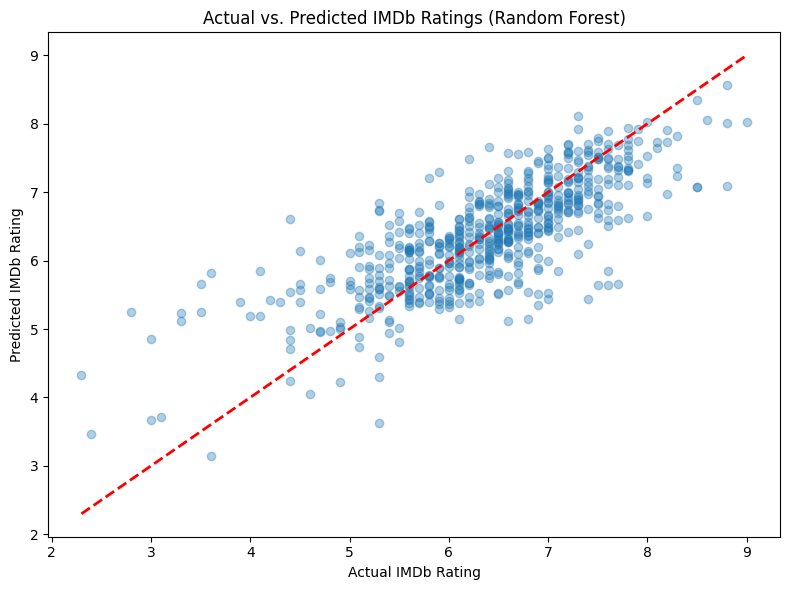

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.35)
plt.plot(
    [y_test_reg.min(), y_test_reg.max()],
    [y_test_reg.min(), y_test_reg.max()],
    'r--', linewidth=2
)
plt.xlabel("Actual IMDb Rating")
plt.ylabel("Predicted IMDb Rating")
plt.title("Actual vs. Predicted IMDb Ratings (Random Forest)")
plt.tight_layout()
plt.show()


The Actual vs. Predicted plot shows that most predictions cluster around the
diagonal reference line, confirming the model’s ability to capture the overall
relationship between the input features and IMDb ratings.


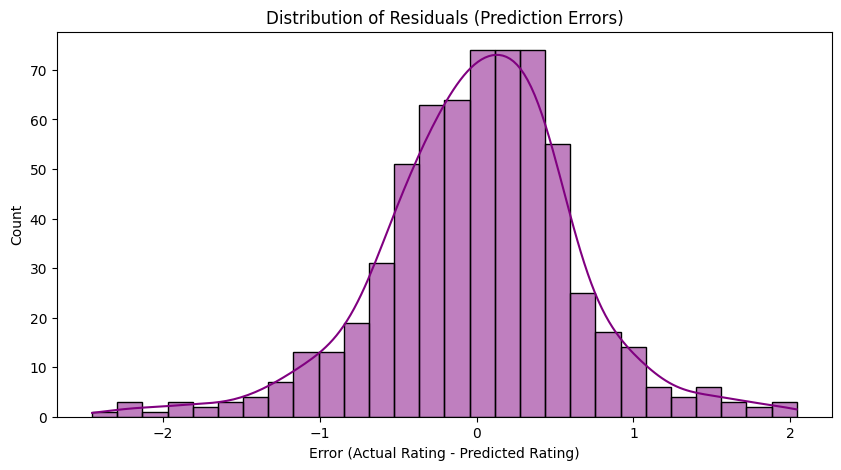

In [15]:
# Calculate residuals
y_pred_reg = reg_model.predict(X_test)
residuals = y_test_reg - y_pred_reg

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title("Distribution of Residuals (Prediction Errors)")
plt.xlabel("Error (Actual Rating - Predicted Rating)")
plt.show()

## Feature Importance Analysis

Feature importances extracted from the Random Forest model are used to interpret which variables contribute most to predicting IMDb ratings and to compare results with earlier hypotheses.


In [16]:
rf = reg_model.named_steps['model']
ohe = reg_model.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot']

feature_names = np.concatenate([
    numeric_features,
    ohe.get_feature_names_out(categorical_features)
])

fi = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

fi.head(10)


,feature,importance
2,omdb_metascore,0.586642
1,worldwide,0.117337
0,budget,0.088216
3,Year,0.074874
4,oscar_winner_flag,0.017820
12,genre_1_Documentary,0.014157
13,genre_1_Drama,0.013359
25,mpaa_R,0.011816
5,oscar_nominee_flag,0.010475
10,genre_1_Comedy,0.009808


/tmp/ipython-input-3906933769.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi.head(10), palette='magma')


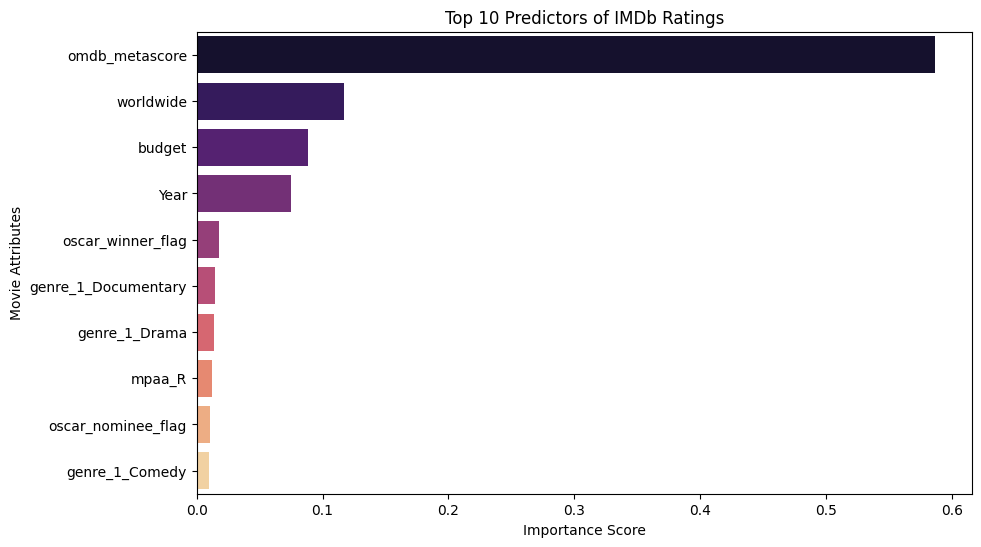

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=fi.head(10), palette='magma')
plt.title("Top 10 Predictors of IMDb Ratings")
plt.xlabel("Importance Score")
plt.ylabel("Movie Attributes")
plt.show()

## Classification Task — High Appreciation Movies

In this task, movies are classified into two categories based on audience reception:

- **General Appreciation**: IMDb Rating < 7.5  
- **High Appreciation**: IMDb Rating ≥ 7.5  

We apply the **K-Nearest Neighbors (KNN)** algorithm, which assigns class labels based on similarity to neighboring observations in the feature space. Distance-based classification makes KNN sensitive to feature scaling, which is handled in the preprocessing pipeline.

---

## Model Setup

The classification model is implemented using a pipeline consisting of:

- **Preprocessing**:  
  - Numeric feature scaling  
  - One-hot encoding for categorical variables  
- **Classifier**:  
  - KNeighborsClassifier with *k = 11*

This pipeline structure ensures consistent preprocessing during both training and testing while preventing data leakage.


In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

clf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=11))
])

clf_model.fit(X_train, y_train_clf)
y_pred_clf = clf_model.predict(X_test)

print(classification_report(
    y_test_clf,
    y_pred_clf,
    target_names=['General', 'High']
))


              precision    recall  f1-score   support

     General       0.92      0.96      0.94       558
        High       0.58      0.39      0.47        77

    accuracy                           0.89       635
   macro avg       0.75      0.68      0.70       635
weighted avg       0.88      0.89      0.88       635



## Classification Results — High Appreciation Prediction

The overall classification accuracy is **0.89**, indicating strong performance in predicting the dominant class.  
However, class-level metrics reveal an important asymmetry between the two appreciation categories.



## Class-wise Performance Analysis

### General Appreciation Movies

- **Precision**: 0.92  
- **Recall**: 0.96  
- **F1-score**: 0.94  

The model performs very well for General Appreciation movies, correctly identifying most instances with high confidence.

---

### High Appreciation Movies

- **Precision**: 0.58  
- **Recall**: 0.39  
- **F1-score**: 0.47  

Performance is notably weaker for High Appreciation movies. Although predictions labeled as *High* are moderately precise, the low recall indicates that many truly high-rated movies are not detected.

---

## Interpretation

The classifier exhibits conservative behavior when predicting High Appreciation films. This outcome is primarily driven by:

- **Class imbalance**, with High Appreciation movies forming a minority of the dataset  
- **Feature overlap** between moderately rated and highly rated films  
- The inherent difficulty of predicting exceptional audience reception from numeric features alone  

These results suggest that while classification provides useful insights, regression-based modeling offers a more informative framework for capturing audience rating behavior.


## Classification Evaluation

Classification performance is evaluated using a confusion matrix and ROC–AUC to assess both class-specific accuracy and overall discriminative ability.


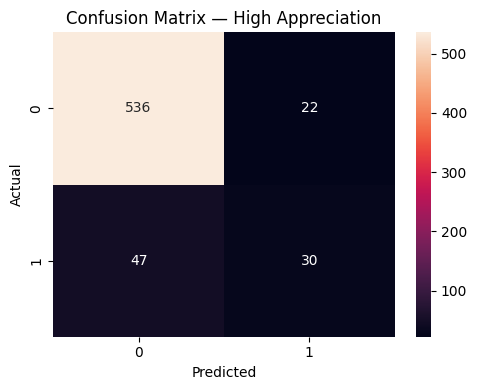

ROC-AUC: 0.8289


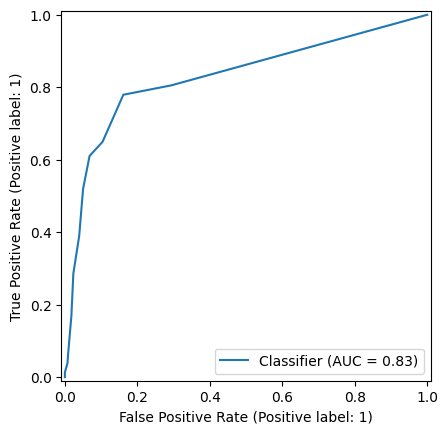

In [19]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

cm = confusion_matrix(y_test_clf, y_pred_clf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — High Appreciation")
plt.tight_layout()
plt.show()

y_prob = clf_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test_clf, y_prob)
print(f"ROC-AUC: {auc:.4f}")

RocCurveDisplay.from_predictions(y_test_clf, y_prob)
plt.show()


## Confusion Matrix Interpretation

The confusion matrix highlights the model’s decision behavior:

- **True Negatives (General correctly predicted):** 536  
- **False Positives (General predicted as High):** 22  
- **False Negatives (High predicted as General):** 47  
- **True Positives (High correctly predicted):** 30  

The relatively high number of false negatives indicates that many high-rated movies are classified as general appreciation, reinforcing the conservative nature of the classifier.


## ROC–AUC Analysis

The classifier achieves a **ROC–AUC score of 0.829**, indicating strong discriminative ability between High and General Appreciation movies.

An AUC above 0.8 suggests that the model effectively ranks high-rated movies above lower-rated ones, even if the default classification threshold does not capture all high-appreciation cases. This implies that adjusting the decision threshold could improve recall for high-rated movies.


### **Personal vs. Model Prediction**
I applied the trained model to the subset of movies I personally rated to see if
the 'General Public' model aligns with my individual taste.

In [20]:
# Filter rows where you have personal ratings
personal_df = df.dropna(subset=['MyRating'])
X_personal = personal_df[numeric_features + categorical_features]
y_personal = personal_df['MyRating']

# Predict using the general model
my_preds = reg_model.predict(X_personal)

print(f"Model Accuracy on My Taste (R2): {r2_score(y_personal, my_preds):.4f}")

Model Accuracy on My Taste (R2): 0.4710


## Key Findings from Phase 3

- Financial and critical indicators provide meaningful predictive power for IMDb ratings, explaining approximately 60% of the variance in audience scores.
- Metascore and award-related variables contribute more strongly than production budget alone, supporting earlier hypothesis-testing results.
- High audience appreciation is inherently more difficult to predict than average reception, reflecting the subjective and nonlinear nature of movie success.
- While predictive performance is strong, the observed relationships are associative and do not imply causation.

---

## Limitations and Model Behavior

- The dataset is imbalanced, with fewer High Appreciation movies, which negatively affects recall for the minority class.
- The classification model prioritizes precision over recall when predicting high-rated films, leading to conservative predictions.
- IMDb ratings are subjective and influenced by unobserved factors such as cultural context, marketing strategies, and release timing.

Future work may explore threshold tuning, cost-sensitive learning, or temporal modeling approaches to better capture high-appreciation outcomes.


